In [71]:
import pandas as pd
import numpy as np
import joblib
from plotnine import *

import os 
print(os.getcwd())

from sqlalchemy import create_engine
import mysql.connector

# model 
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

/home/ubuntu/projects/Prophet


# Database Connection

In [9]:
config=cp.ConfigParser()
config.read('/home/ubuntu/cert/db_login.txt')
db_config=config['ivan_db']

engine=create_engine('mysql+mysqlconnector://{0:s}:{1:s}@{2:s}/{3:s}'.format(db_config['userid'],
                                                                             db_config['pwd'],
                                                                             db_config['hostname'],
                                                                             'STOCK_PRED'))

## Download data 


In [23]:
# Saving
#joblib.dump(df,'data/sp_500_stock_price_march15.pkl')

In [25]:
print(df.shape,df.Date.nunique(),df.Stock.nunique())
df.head(5)

(4058564, 9) 15674 483


,Date,Open,High,Low,Close,Volume,SE,Stock,REFRESH_DATE
0,2005-09-27,19.844708,20.174668,18.006363,18.194910,961200.0,NASDAQ,AAL,2021-08-15
1,2005-09-28,18.194908,19.354481,18.100635,19.326199,5747900.0,NASDAQ,AAL,2021-08-15
2,2005-09-29,19.231922,19.401616,18.949101,19.052801,1078200.0,NASDAQ,AAL,2021-08-15
3,2005-09-30,19.099943,19.844708,19.024524,19.806999,3123300.0,NASDAQ,AAL,2021-08-15
4,2005-10-03,19.703293,20.504623,19.703293,20.268938,1057900.0,NASDAQ,AAL,2021-08-15


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4058564 entries, 0 to 4058563
Data columns (total 9 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Date          datetime64[ns]
 1   Open          float64       
 2   High          float64       
 3   Low           float64       
 4   Close         float64       
 5   Volume        float64       
 6   SE            object        
 7   Stock         object        
 8   REFRESH_DATE  datetime64[ns]
dtypes: datetime64[ns](2), float64(5), object(2)
memory usage: 278.7+ MB


# Preprocessing

## Reviewing 

In [31]:
df.groupby('Date').agg(num_records=('Date','size'),
                       cnt_stock=('Stock','nunique')
                      ).sort_values(by='Date').reset_index(drop=False)#.loc[lambda x:x.num_records!=x.cnt_stock]

,Date,num_records,cnt_stock
0,1962-01-02,16,16
1,1962-01-03,16,16
2,1962-01-04,16,16
3,1962-01-05,16,16
4,1962-01-08,16,16
...,...,...,...
15669,2024-03-13,483,483
15670,2024-03-14,483,483
15671,2024-03-18,483,483
15672,2024-03-19,483,483


## NAs & Negative 

In [36]:
## NAs
pd.DataFrame({'vals':df.isnull().sum()}).loc[lambda x:x.vals>0,:]

,vals
Open,161
High,161
Low,161
Close,161
Volume,161


In [38]:
df.loc[df.Open.isnull(),'Stock'].value_counts()

MSI     2
BAC     2
NOC     2
MS      2
MOS     2
       ..
KDP     1
CARR    1
FI      1
WMB     1
TECH    1
Name: Stock, Length: 145, dtype: int64

In [45]:
## Negative
pd.DataFrame({'vals':df.select_dtypes(include='number').apply(lambda x:(x<0).astype(float).sum())})#.loc[lambda x:x.vals>0]

,vals
Open,0.0
High,0.0
Low,0.0
Close,0.0
Volume,0.0


## Filtering 

In [49]:
df_2=df.copy()
df_2=df_2.loc[df_2.Date<pd.to_datetime('2024-03-15',format='%Y-%m-%d'),:]
print(df_2.shape)
df_2.Date.describe()

(4057115, 9)


/tmp/ipykernel_341876/148623350.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_2.Date.describe()


count                 4057115
unique                  15671
top       2024-03-14 00:00:00
freq                      483
first     1962-01-02 00:00:00
last      2024-03-14 00:00:00
Name: Date, dtype: object

In [52]:
## Remove NAs
df_2=df_2.loc[~df_2.Open.isnull(),:]
print(df_2.shape)
print(df_2.Stock.nunique())
pd.DataFrame({'vals':df_2.isnull().sum()}).loc[lambda x:x.vals>0,:]

(4056954, 9)
483


,vals


# Stock Overview
* https://rdrr.io/cran/prophet/man/make_future_dataframe.html

In [66]:
df_last365=df_2.loc[df_2.Date>=pd.to_datetime('2021-01-01',format='%Y-%m-%d'),:]

df_last365.sort_values(by=['Stock','Date'],ascending=True,inplace=True)
print(df_last365.shape)

(384877, 9)


/tmp/ipykernel_341876/1577948888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last365.sort_values(by=['Stock','Date'],ascending=True,inplace=True)


In [68]:
stock_growth_365=df_last365.groupby('Stock').agg(start_date=('Date','first'),
                                                 end_date=('Date','last'),
                                                 first_close=('Close','first'),
                                                 last_close=('Close','last'),
                                                 
                                                ).reset_index(drop=False
                                                             ).assign(growth_rate=lambda x:(x.last_close-x.first_close)/x.first_close)
print(stock_growth_365.shape)

(483, 6)


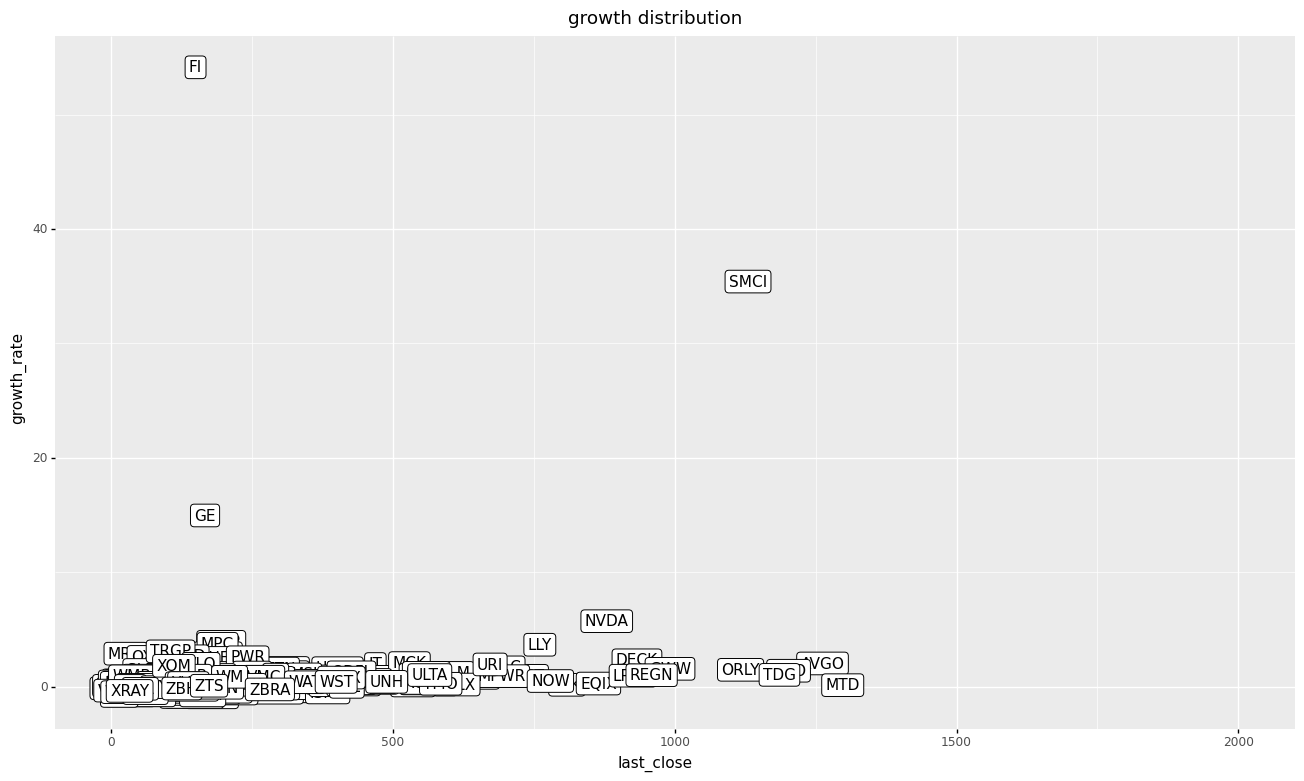

In [76]:
print(
    ggplot(stock_growth_365,aes('last_close','growth_rate'))
    +geom_point(color='blue')
    +geom_label(aes(label='Stock'))
    +theme(figure_size=(16,9))
    +labs(title='growth distribution')
    +coord_cartesian(xlim=(0,2000))
)

In [77]:
stock_growth_365.sort_values(by='growth_rate',ascending=False)

,Stock,start_date,end_date,first_close,last_close,growth_rate
177,FI,2021-01-04,2024-03-14,2.720000,149.940002,54.125000
397,SMCI,2021-01-04,2024-03-14,31.049999,1130.109985,35.396458
190,GE,2021-01-04,2024-03-14,10.454329,166.750000,14.950329
331,NVDA,2021-01-04,2024-03-14,131.059723,879.440002,5.710223
63,BLDR,2021-01-04,2024-03-14,39.830002,195.419998,3.906352
...,...,...,...,...,...,...
313,MTCH,2021-01-04,2024-03-14,149.919998,33.320000,-0.777748
451,VFC,2021-01-04,2024-03-14,84.088516,14.600000,-0.826373
197,GOOG,2021-01-04,2024-03-14,1728.239990,144.339996,-0.916482
198,GOOGL,2021-01-04,2024-03-14,1726.130005,143.100006,-0.917098


# 1. Model Configuration - MSFT

## 1.1 Analysis 

In [78]:
stock_growth_365.loc[stock_growth_365.Stock=='MSFT']

,Stock,start_date,end_date,first_close,last_close,growth_rate
310,MSFT,2021-01-04,2024-03-14,216.689423,425.220001,0.962348


In [82]:
df_MSFT=df_2.loc[df_2.Stock=='MSFT',:]
print(df_MSFT.shape)
df_MSFT.iloc[[0,-1],:]

(9574, 9)


,Date,Open,High,Low,Close,Volume,SE,Stock,REFRESH_DATE
578173,1986-03-13,0.056108,0.064359,0.056108,0.061608,1.031789e+09,NASDAQ,MSFT,2021-08-15 00:00:00
4056718,2024-03-14,420.239990,427.820007,417.989990,425.220001,3.411310e+07,NASDAQ,MSFT,2024-03-15 01:46:28


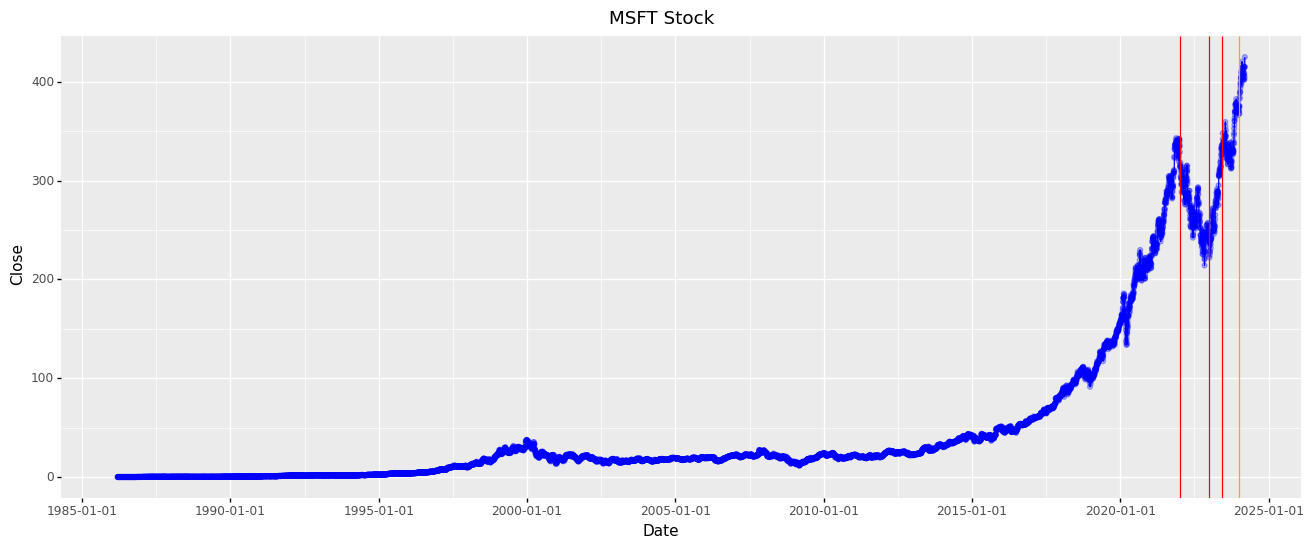

In [87]:
print(
    ggplot(df_MSFT,aes('Date','Close'))
    +geom_point(color='blue',alpha=0.3)
    +geom_line(color='blue')
    +geom_vline(xintercept=[pd.to_datetime('2022-01-01'),
                            pd.to_datetime('2023-01-01'),
                            pd.to_datetime('2023-06-01'),
                            pd.to_datetime('2024-01-01')
                           ],
                color=['red','red','red','orange']
               )
    +theme(figure_size=(16,6))
    +labs(title='MSFT Stock')
)

## 1.2 Model Configuration - Before 2022-01-01

In [91]:
df_MSFT_2022_train=df_MSFT.loc[df_MSFT.Date<pd.to_datetime('2022-01-01'),
                               :].sort_values(by='Date',ascending=True).reset_index(drop=True)
df_MSFT_2022_train.rename(columns={'Date':'ds','Close':'y'},inplace=True)
df_MSFT_2022_train

,ds,Open,High,Low,y,Volume,SE,Stock,REFRESH_DATE
0,1986-03-13,0.056108,0.064359,0.056108,0.061608,1.031789e+09,NASDAQ,MSFT,2021-08-15 00:00:00
1,1986-03-14,0.061609,0.064909,0.061609,0.063809,3.081600e+08,NASDAQ,MSFT,2021-08-15 00:00:00
2,1986-03-17,0.063809,0.065459,0.063809,0.064909,1.331712e+08,NASDAQ,MSFT,2021-08-15 00:00:00
3,1986-03-18,0.064909,0.065459,0.062709,0.063259,6.776640e+07,NASDAQ,MSFT,2021-08-15 00:00:00
4,1986-03-19,0.063259,0.063809,0.061608,0.062159,4.789440e+07,NASDAQ,MSFT,2021-08-15 00:00:00
...,...,...,...,...,...,...,...,...,...
9020,2021-12-27,335.459991,342.480011,335.429993,342.450012,1.994700e+07,NASDAQ,MSFT,2022-01-05 03:00:45
9021,2021-12-28,343.149994,343.809998,340.320007,341.250000,1.566150e+07,NASDAQ,MSFT,2022-01-05 03:00:45
9022,2021-12-29,341.299988,344.299988,339.679993,341.950012,1.504200e+07,NASDAQ,MSFT,2022-01-05 03:00:45
9023,2021-12-30,341.910004,343.130005,338.820007,339.320007,1.599450e+07,NASDAQ,MSFT,2022-01-05 03:00:45


### Configuration 

In [ ]:
## Configuration
msft_2022_m=Prophet(seasonality_mode='multiplicative',
                    mcmc_samples=300).fit(df_MSFT_2022_train.loc[:,['ds','y']])

05:00:42 - cmdstanpy - INFO - CmdStan installation /home/ubuntu/anaconda3/lib/python3.9/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
05:00:42 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
05:00:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

### Create Forecast Table 

In [102]:
msft_2022_future=msft_2022_m.make_future_dataframe(periods=90, freq='B')
msft_2022_forecast=msft_2022_m.predict(msft_2022_future)

In [106]:
#msft_2022_forecast

### Review 

#### Default function 

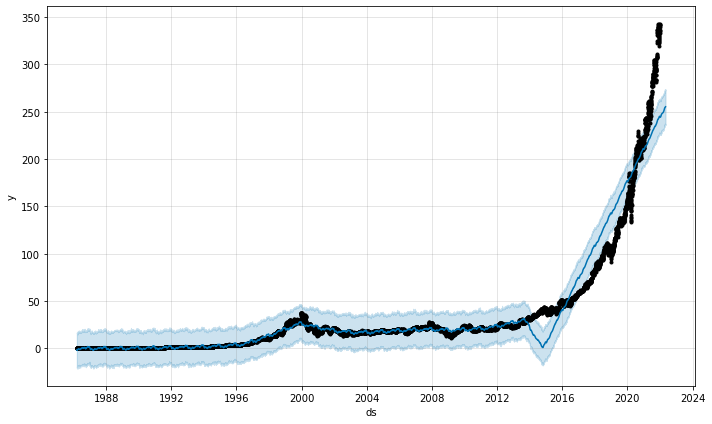

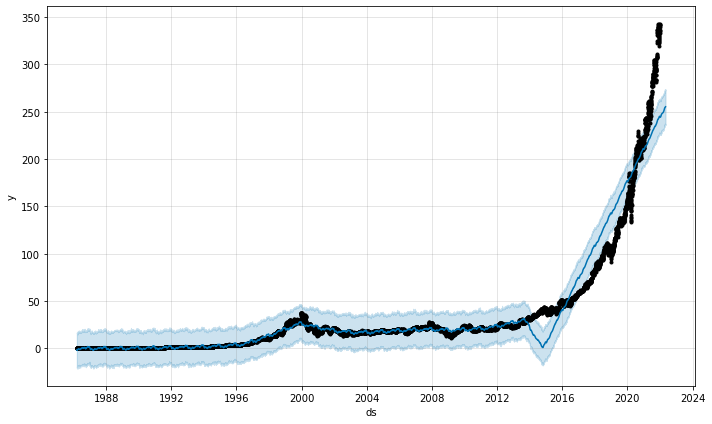

In [103]:
msft_2022_m.plot(msft_2022_forecast)

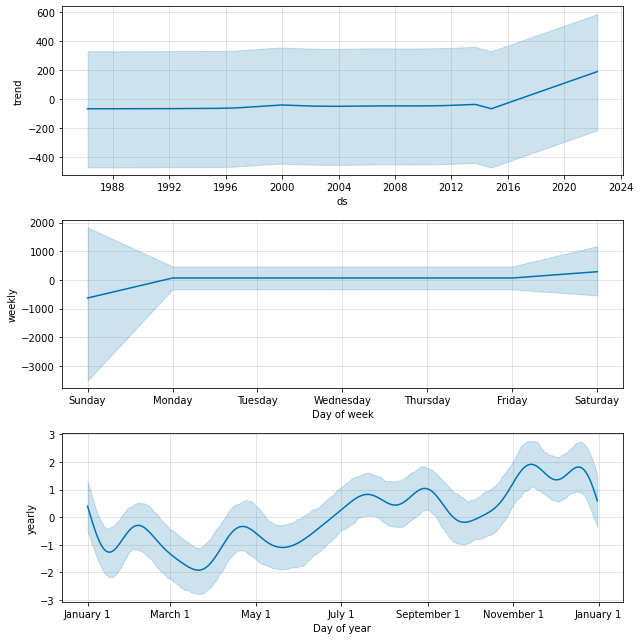

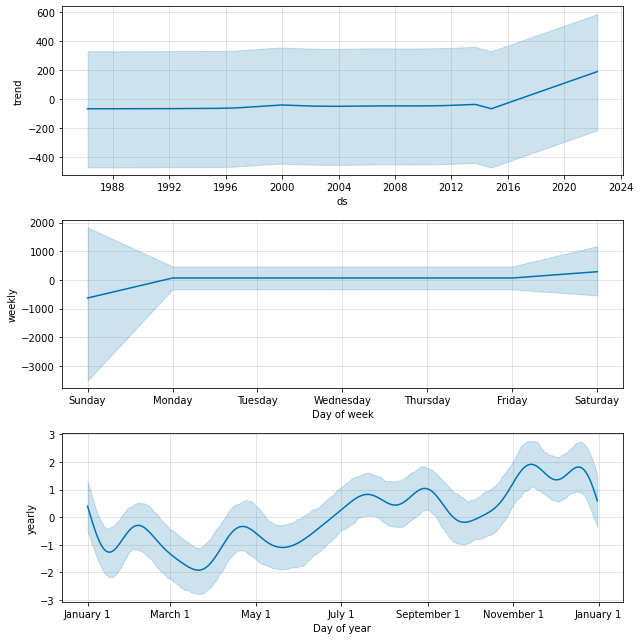

In [108]:
msft_2022_m.plot_components(msft_2022_forecast)

#### Ivan Analysis 